The gradient is the slope of the loss function and points in the direction of fastest change.

Backpropagation is really just an application of the chain rule from calculus.

The goal is to adjust the weights and biases to minimize the loss.

We update our weights using this gradient with some learning rate.

## Losses in PyTorch

Let's start by seeing how we calculate the loss with PyTorch. Through the `nn` module, PyTorch provides losses such as the cross-entropy loss (`nn.CrossEntropyLoss`). You'll usually see the loss assigned to `criterion`. As noted in the last part, with a classification problem such as MNIST, we're using the softmax function to predict class probabilities. With a softmax output, you want to use cross-entropy as the loss. To actually calculate the loss, you first define the criterion then pass in the output of your network and the correct labels.

Something really important to note here. Looking at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ])

# Download and load the trainin data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/',
                          download=True,
                          train=True,
                          transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=64,
                                          shuffle=True)

In [2]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.2871, grad_fn=<NllLossBackward>)


In my experience it's more convenient to build the model with a log-softmax output using `nn.LogSoftmax` or `F.log_softmax` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax)). Then you can get the actual probabilites by taking the exponential `torch.exp(output)`. With a log-softmax output, you want to use the negative log likelihood loss, `nn.NLLLoss` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss)).

>**Exercise:** Build a model that returns the log-softmax as the output and calculate the loss using the negative log likelihood loss.

In [3]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# Define the loss
criterion = nn.NLLLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3217, grad_fn=<NllLossBackward>)


## Autograd

Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way.

To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set *requires_grad=True* on a tensor.

In [4]:
x = torch.zeros(1, requires_grad=True)
x.requires_grad

True

In [5]:
with torch.no_grad():
    y = x * 2
y.requires_grad

False

Also, you can turn on or off gradients altogether with *torch.set_grad_enabled(True|False)*

The gradients are computed with respect to some variable z with z.backward(). This does a backward pass through the operations that created z.

In [6]:
x = torch.randn(2, 2, requires_grad=True)
print(x)

tensor([[-0.4708, -0.1777],
        [ 1.2753,  0.1114]], requires_grad=True)


In [7]:
y = x**2
print(y)

tensor([[0.2216, 0.0316],
        [1.6264, 0.0124]], grad_fn=<PowBackward0>)


In [8]:
# grad_fn shows the function that generated this Variable
print(y.grad_fn)

In [9]:
z = y.mean()
print(z)

tensor(0.4730, grad_fn=<MeanBackward0>)


In [10]:
print(x.grad)

None


To calculate the gradients, you need to run the *.backward* method on a Variable, z for example.

In [11]:
z.backward()
print(x.grad)
print(x/2)

tensor([[-0.2354, -0.0889],
        [ 0.6376,  0.0557]])
tensor([[-0.2354, -0.0889],
        [ 0.6376,  0.0557]], grad_fn=<DivBackward0>)


Once we have the gradients we can make a gradient descent step.

## Loss and Autograd together

When we create a network with PyTorch, all of the parameters are initialized with `requires_grad = True`. This means that when we calculate the loss and call `loss.backward()`, the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent. Below you can see an example of calculating the gradients using a backwards pass.

In [12]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# Define the loss
criterion = nn.NLLLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

In [13]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0009,  0.0009,  0.0009,  ...,  0.0009,  0.0009,  0.0009],
        [-0.0033, -0.0033, -0.0033,  ..., -0.0033, -0.0033, -0.0033],
        [ 0.0007,  0.0007,  0.0007,  ...,  0.0007,  0.0007,  0.0007],
        ...,
        [ 0.0034,  0.0034,  0.0034,  ...,  0.0034,  0.0034,  0.0034],
        [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
        [-0.0015, -0.0015, -0.0015,  ..., -0.0015, -0.0015, -0.0015]])


## Training the network!

We need an optimizer to use to update the weights with the gradients.

In [14]:
from torch import optim

# Optimizers require the parameters to optimize and
# a learning rate
optimizer = optim.SGD(model.parameters(),
                      lr=0.01)

The general process with PyTorch:
- Make a forward pass through the network
- Use the network output to calculate the loss
- Perform a backward pass through the network with loss.backward() to calculate the gradients
- Take a step with the optimizer to update the weights

Remember to use *optimizer.zero_grad()*. When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means we need to zero the gradients on each training pass or we'll retain gradients from previous training batches.

Here is the one training step:

In [15]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients
optimizer.zero_grad()

# Forward pass, then backward pass and update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient - ', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[ 0.0032,  0.0293, -0.0309,  ...,  0.0206, -0.0225,  0.0279],
        [-0.0137, -0.0155,  0.0206,  ..., -0.0288,  0.0034,  0.0259],
        [-0.0050, -0.0347,  0.0315,  ...,  0.0195,  0.0042,  0.0218],
        ...,
        [ 0.0356, -0.0122,  0.0204,  ...,  0.0125,  0.0171, -0.0309],
        [ 0.0204, -0.0007, -0.0161,  ..., -0.0352,  0.0092, -0.0046],
        [ 0.0071,  0.0247, -0.0218,  ...,  0.0075, -0.0205,  0.0033]],
       requires_grad=True)
Gradient -  tensor([[ 0.0012,  0.0012,  0.0012,  ...,  0.0012,  0.0012,  0.0012],
        [ 0.0013,  0.0013,  0.0013,  ...,  0.0013,  0.0013,  0.0013],
        [-0.0001, -0.0001, -0.0001,  ..., -0.0001, -0.0001, -0.0001],
        ...,
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        [-0.0012, -0.0012, -0.0012,  ..., -0.0012, -0.0012, -0.0012],
        [-0.0029, -0.0029, -0.0029,  ..., -0.0029, -0.0029, -0.0029]])


In [16]:
# Take an update step and few the new weights
optimizer.step()
print('Initial weights - ', model[0].weight)

Initial weights -Parameter containing:
tensor([[ 0.0032,  0.0292, -0.0309,  ...,  0.0206, -0.0225,  0.0279],
        [-0.0137, -0.0155,  0.0206,  ..., -0.0289,  0.0034,  0.0259],
        [-0.0050, -0.0347,  0.0315,  ...,  0.0195,  0.0042,  0.0218],
        ...,
        [ 0.0356, -0.0122,  0.0204,  ...,  0.0125,  0.0171, -0.0309],
        [ 0.0204, -0.0007, -0.0160,  ..., -0.0351,  0.0092, -0.0045],
        [ 0.0071,  0.0247, -0.0217,  ...,  0.0076, -0.0205,  0.0033]],
       requires_grad=True)


## Training for real

One pass through the entire dataset is called an *epoch*. So here we're going to loop through `trainloader` to get our training batches. For each batch, we'll doing a training pass where we calculate the loss, do a backwards pass, and update the weights.

> **Exercise: ** Implement the training pass for our network. If you implemented it correctly, you should see the training loss drop with each epoch.

In [17]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# Define the loss
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=0.003)

epochs = 5

for epoch in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        # Flatten MNIST images
        images = images.view(images.shape[0], -1)
        
        # Clear the gradients
        optimizer.zero_grad()
        # Forward pass, get our logits
        logits = model(images)
        # Calculate the loss with the logits and the labels
        loss = criterion(logits, labels)
        loss.backward()
        # Take an update step and few the new weights
        optimizer.step()
        running_loss += loss.item()
    else:
        print(f"Training loss: \
                {running_loss/len(trainloader)}")

Training loss:                 1.836987315972985
Training loss:                 0.8030743170013306
Training loss:                 0.519039797090264
Training loss:                 0.4248203492240865
Training loss:                 0.38073850054540104


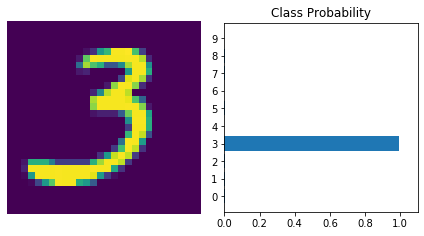

In [18]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)

# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)
    
# output the network are log-probabilities,
# need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)